In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import matplotlib as mpl
import pandas as pd
import numpy as np
import re
from transformers import pipeline

We will perform sentiment analysis at the paragraph level for all the National Day Rally speeches from 2004 to 2022. We will compare two sentiment analysis packages for this task: Hugging Face and VADER.

**1. Hugging Face**

In [2]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2022_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()
    
# Convert into dataframes, split by sentences
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paragraphs"})

In [3]:
# Pre-processing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Paragraphs'].map(lambda text: clean_text(text))

In [4]:
corpus = list(df['Clean_Text'].values)

In [5]:
nlp_sentiment = pipeline("sentiment-analysis", model= "distilbert-base-uncased-finetuned-sst-2-english" )  
#using 'sentiment-analysis'same as "text-classification" 

In [6]:
#df["Sentiment"] = nlp_sentiment(corpus)

Running the above quote will result in the error below which means that Hugging Face can only deal with max 512 tokens (words):
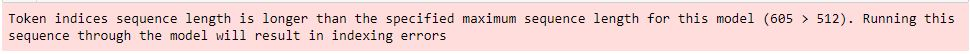

Since some of our paragraphs are longer than 512 tokens (words), further processing needs to be done to continue using Hugging Face:
1. Split paragraphs into sentences
2. Perform sentiment analysis at the sentence level
3. For each paragraph, take the average of the sentence sentiment score of all sentiments to derive the sentiment score for each paragraph


In [7]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2022_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

In [8]:
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

# calculate lengths of splits using full stops as we are looking for sentences
lens = df['Paragraphs'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
df = pd.DataFrame({'ParasNo': np.repeat(df['ParasNo'], lens),
                    'Sentences': chainer(df['Paragraphs'])}) 

df.reset_index(inplace=True, drop=True)

In [9]:
# Pre-processing

#Drop rows with empty strings 
df.drop(index=df[df['Sentences'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Sentences'].map(lambda text: clean_text(text))

In [10]:
df.head()

,ParasNo,Sentences,Clean_Text
0,0,My fellow Singaporeans,my fellow singaporeans
1,1,Good evening,good evening
2,2,COVID-19,covid
3,3,We have come a long way in our fight against C...,we have come a long way in our fight against c...
4,3,We are now learning to live with the virus,we are now learning to live with the virus


In [11]:
corpus = list(df['Clean_Text'].values)

In [12]:
nlp_sentiment = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")

In [13]:
%%time
df["Sentiment"] = nlp_sentiment(corpus)

Wall time: 14.7 s


In [14]:
# Extract pipeline's sentiment analysis output that consists of a label and a score into separate columns

df['Sentiment_Label'] = [x.get('label') for x in df['Sentiment']]
df['Sentiment_Score'] = [x.get('score') for x in df['Sentiment']]

In [15]:
df.head()

,ParasNo,Sentences,Clean_Text,Sentiment,Sentiment_Label,Sentiment_Score
0,0,My fellow Singaporeans,my fellow singaporeans,"{'label': 'POSITIVE', 'score': 0.9980775117874...",POSITIVE,0.998078
1,1,Good evening,good evening,"{'label': 'POSITIVE', 'score': 0.9998613595962...",POSITIVE,0.999861
2,2,COVID-19,covid,"{'label': 'POSITIVE', 'score': 0.9856761693954...",POSITIVE,0.985676
3,3,We have come a long way in our fight against C...,we have come a long way in our fight against c...,"{'label': 'POSITIVE', 'score': 0.9546213150024...",POSITIVE,0.954621
4,3,We are now learning to live with the virus,we are now learning to live with the virus,"{'label': 'POSITIVE', 'score': 0.9938626289367...",POSITIVE,0.993863


Each sentence has a sentiment label and a corresponding score. The score  tells you how positive or negative a sentence is.
E.g. Sentiment_Label = Positive and Sentiment_Score = 0.957 means it is very very positive ; 
E.g. Sentiment_Label = Negative and Sentiment_Score = 0.788761 means it is very negative.

We first transform the negative sentiment scores into the negative scale
E.g. Sentiment Label, Score = Negative, 0.788 --> Negative, -0.788

Thereafter, we will take the average of the scores to derive how positive of negative a paragraph is.
The threshold used is >= 0.5 for positive and <0.5 for negative.

In [16]:
#Create new column to store scores
df['HF_Score'] = df['Sentiment_Score']

#Update the scores' for rows of negative sentiment by converting it to the negative scale
mask = (df['Sentiment_Label'] == 'NEGATIVE')
df.loc[mask, 'HF_Score'] = - df['Sentiment_Score']

#Take the average of the sentence scores and store in a new dataframe
df_hf = df.groupby(['ParasNo']).mean('HF_Score')
df_hf.drop(columns='Sentiment_Score',axis = 1, inplace=True)

#Assign Sentiment Label for each paragraph where sentiment is positive if score >= 0.50, and negative otherwise. 
df_hf['HF_Label'] = np.where(df_hf['HF_Score']>=0, "POSITIVE","NEGATIVE")
df_hf['HF_Label'].value_counts()

POSITIVE    73
NEGATIVE    32
Name: HF_Label, dtype: int64

### 2. Sentiment Analysis using VADER

In [17]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [18]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2022_eng.txt', 'r', encoding="utf8") as file_to_read:
    df_v = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df_v = (pd.DataFrame(df_v.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df_v['ParasNo'] = df_v.index

In [19]:
# Pre-processing
#Drop rows with empty strings 
df_v.drop(index=df_v[df_v['Paragraphs'] == ''].index, inplace=True)
df_v.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df_v["Clean_Text"] = df_v['Paragraphs'].map(lambda text: clean_text(text))

In [20]:
df_v.head()

,Paragraphs,ParasNo,Clean_Text
0,My fellow Singaporeans,0,my fellow singaporeans
1,Good evening.,1,good evening
2,COVID-19,2,covid
3,We have come a long way in our fight against C...,3,we have come a long way in our fight against c...
4,"In many other countries, when a wave happens, ...",4,in many other countries when a wave happens ...


In [21]:
%%time
df_v['scores'] = df_v['Clean_Text'].apply(lambda x: sid.polarity_scores(x))
df_v.head()

Wall time: 166 ms


,Paragraphs,ParasNo,Clean_Text,scores
0,My fellow Singaporeans,0,my fellow singaporeans,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Good evening.,1,good evening,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp..."
2,COVID-19,2,covid,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,We have come a long way in our fight against C...,3,we have come a long way in our fight against c...,"{'neg': 0.063, 'neu': 0.867, 'pos': 0.07, 'com..."
4,"In many other countries, when a wave happens, ...",4,in many other countries when a wave happens ...,"{'neg': 0.153, 'neu': 0.694, 'pos': 0.152, 'co..."


In [22]:
#Separate out the compound score
df_v['VADER_Score']  = df_v['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df_v['VADER_Label'] = df_v['VADER_Score'].apply(lambda c: 'POSITIVE' if c >0 else 'NEGATIVE' if c<0 else 'NEUTRAL') #(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu') #lambda c: 'POSITIVE' if c >=0 else 'NEGATIVE'

df_v.head() 

,Paragraphs,ParasNo,Clean_Text,scores,VADER_Score,VADER_Label
0,My fellow Singaporeans,0,my fellow singaporeans,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1,Good evening.,1,good evening,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,POSITIVE
2,COVID-19,2,covid,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
3,We have come a long way in our fight against C...,3,we have come a long way in our fight against c...,"{'neg': 0.063, 'neu': 0.867, 'pos': 0.07, 'com...",0.0772,POSITIVE
4,"In many other countries, when a wave happens, ...",4,in many other countries when a wave happens ...,"{'neg': 0.153, 'neu': 0.694, 'pos': 0.152, 'co...",-0.2732,NEGATIVE


### 3. Comparison

In [23]:
df_compare_2022 = pd.merge(df_v[['ParasNo','Paragraphs', 'VADER_Score', 'VADER_Label']], df_hf, how='inner', on='ParasNo')

In [24]:
df_compare_2022['Difference'] = np.where(df_compare_2022["HF_Label"]!=df_compare_2022['VADER_Label'],'Opposing','Same')
df_compare_2022['Difference'].value_counts()

Same        68
Opposing    37
Name: Difference, dtype: int64

There are 30 paragraphs with opposing labels. 
To select 5 for comparison, we selected out paragraphs where each algorithm gave a relatively higher score (>0.30) in the respective labelled polarity.

In [25]:
df_compare_2022[(df_compare_2022['Difference'] == 'Opposing') & (abs(df_compare_2022['HF_Score']) >0.30) & (abs(df_compare_2022['VADER_Score']) >0.30)]

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
5,5,"Thus far, we have had fewer than 1,600 COVID-1...",0.5106,POSITIVE,-0.498362,NEGATIVE,Opposing
12,12,"With our situation stabilising, we will reduce...",0.3898,POSITIVE,-0.410867,NEGATIVE,Opposing
25,25,The basic reality is that international econom...,0.6690,POSITIVE,-0.444158,NEGATIVE,Opposing
26,26,We do not have much influence over this global...,0.5945,POSITIVE,-0.337353,NEGATIVE,Opposing
35,35,Even as we navigate through an uncertain and t...,-0.6369,NEGATIVE,0.796876,POSITIVE,Opposing
44,44,Singaporeans still have differing views on whe...,0.6517,POSITIVE,-0.582289,NEGATIVE,Opposing
47,47,"But at the same time, most Singaporeans do not...",0.7945,POSITIVE,-0.909494,NEGATIVE,Opposing
51,51,"However, as the law stands, this definition of...",0.6597,POSITIVE,-0.625398,NEGATIVE,Opposing
60,60,While we deal with sensitive issues like s377A...,0.6908,POSITIVE,-0.525415,NEGATIVE,Opposing


In [26]:
#Randomly selecting 5 paragraphs to review
import random
random.seed(68)
random.sample(list(df_compare_2022[(df_compare_2022['Difference'] == 'Opposing') & (abs(df_compare_2022['HF_Score']) >0.30) & (abs(df_compare_2022['VADER_Score']) >0.30)].ParasNo),k=5)

[51, 12, 35, 47, 60]

### Year 2012

#### Hugging Face

In [27]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2012_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

# calculate lengths of splits using full stops as we are looking for sentences
lens = df['Paragraphs'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
df = pd.DataFrame({'ParasNo': np.repeat(df['ParasNo'], lens),
                    'Sentences': chainer(df['Paragraphs'])}) 

df.reset_index(inplace=True, drop=True)

# Pre-processing

#Drop rows with empty strings 
df.drop(index=df[df['Sentences'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Sentences'].map(lambda text: clean_text(text))

corpus = list(df['Clean_Text'].values)

nlp_sentiment = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")

In [28]:
%%time
df["Sentiment"] = nlp_sentiment(corpus)

Wall time: 23 s


In [29]:
# Extract pipeline's sentiment analysis output that consists of a label and a score into separate columns

df['Sentiment_Label'] = [x.get('label') for x in df['Sentiment']]
df['Sentiment_Score'] = [x.get('score') for x in df['Sentiment']]

#Create new column to store scores
df['HF_Score'] = df['Sentiment_Score']

#Update the scores' for rows of negative sentiment by converting it to the negative scale
mask = (df['Sentiment_Label'] == 'NEGATIVE')
df.loc[mask, 'HF_Score'] = - df['Sentiment_Score']

#Take the average of the sentence scores and store in a new dataframe
df_hf = df.groupby(['ParasNo']).mean('HF_Score')
df_hf.drop(columns='Sentiment_Score',axis = 1, inplace=True)

#Assign Sentiment Label for each paragraph where sentiment is positive if score >= 0.50, and negative otherwise. 
df_hf['HF_Label'] = np.where(df_hf['HF_Score']>=0, "POSITIVE","NEGATIVE")
df_hf['HF_Label'].value_counts()

POSITIVE    38
NEGATIVE    13
Name: HF_Label, dtype: int64

#### VADER

In [30]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2012_eng.txt', 'r', encoding="utf8") as file_to_read:
    df_v = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df_v = (pd.DataFrame(df_v.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df_v['ParasNo'] = df_v.index

# Pre-processing
#Drop rows with empty strings 
df_v.drop(index=df_v[df_v['Paragraphs'] == ''].index, inplace=True)
df_v.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df_v["Clean_Text"] = df_v['Paragraphs'].map(lambda text: clean_text(text))

In [31]:
%%time
df_v['scores'] = df_v['Clean_Text'].apply(lambda x: sid.polarity_scores(x))
df_v.head()

Wall time: 163 ms


,Paragraphs,ParasNo,Clean_Text,scores
0,Friends and fellow Singaporeans,0,friends and fellow singaporeans,"{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'comp..."
1,We have travelled from Third World to First. Y...,1,we have travelled from third world to first y...,"{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'comp..."
2,The next 20 years will see many changes in the...,2,the next years will see many changes in the wo...,"{'neg': 0.044, 'neu': 0.777, 'pos': 0.179, 'co..."
3,We are both a country and a city. So when we l...,3,we are both a country and a city so when we l...,"{'neg': 0.034, 'neu': 0.777, 'pos': 0.189, 'co..."
4,One of the big changes in the world which will...,4,one of the big changes in the world which will...,"{'neg': 0.08, 'neu': 0.874, 'pos': 0.047, 'com..."


In [32]:
#Separate out the compound score
df_v['VADER_Score']  = df_v['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df_v['VADER_Label'] = df_v['VADER_Score'].apply(lambda c: 'POSITIVE' if c >0 else 'NEGATIVE' if c<0 else 'NEUTRAL') #(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu')

df_v.head() 

,Paragraphs,ParasNo,Clean_Text,scores,VADER_Score,VADER_Label
0,Friends and fellow Singaporeans,0,friends and fellow singaporeans,"{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'comp...",0.4767,POSITIVE
1,We have travelled from Third World to First. Y...,1,we have travelled from third world to first y...,"{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'comp...",0.3400,POSITIVE
2,The next 20 years will see many changes in the...,2,the next years will see many changes in the wo...,"{'neg': 0.044, 'neu': 0.777, 'pos': 0.179, 'co...",0.9237,POSITIVE
3,We are both a country and a city. So when we l...,3,we are both a country and a city so when we l...,"{'neg': 0.034, 'neu': 0.777, 'pos': 0.189, 'co...",0.9945,POSITIVE
4,One of the big changes in the world which will...,4,one of the big changes in the world which will...,"{'neg': 0.08, 'neu': 0.874, 'pos': 0.047, 'com...",-0.6560,NEGATIVE


#### 2012 Comparison

In [33]:
df_compare_2012 = pd.merge(df_v[['ParasNo','Paragraphs', 'VADER_Score', 'VADER_Label']], df_hf, how='inner', on='ParasNo')

In [34]:
df_compare_2012['Difference'] = np.where(df_compare_2012["HF_Label"]!=df_compare_2012['VADER_Label'],'Opposing','Same')
df_compare_2012['Difference'].value_counts()

Same        40
Opposing    11
Name: Difference, dtype: int64

In [35]:
df_compare_2012[df_compare_2012['Difference'] == 'Opposing']

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
5,5,"In 1992, the Internet had not yet come to Sing...",0.8047,POSITIVE,-0.034608,NEGATIVE,Opposing
8,8,How will these technological advances affect u...,0.1779,POSITIVE,-0.284489,NEGATIVE,Opposing
11,11,So what should the next chapter of the Singapo...,0.4404,POSITIVE,-0.977439,NEGATIVE,Opposing
14,14,"We have done it in this generation, for this g...",0.9918,POSITIVE,-0.115473,NEGATIVE,Opposing
27,27,The transformation will take some time but I a...,0.9838,POSITIVE,-0.108692,NEGATIVE,Opposing
28,28,A BIGGER HEART,0.0000,NEUTRAL,0.999874,POSITIVE,Opposing
30,30,"If you look ahead, the state is bound to spend...",0.9445,POSITIVE,-0.123764,NEGATIVE,Opposing
31,31,The second message is that social safety nets ...,0.7578,POSITIVE,-0.435775,NEGATIVE,Opposing
35,35,But I would be less than honest if I did not t...,0.4273,POSITIVE,-0.198967,NEGATIVE,Opposing
40,40,Many Singaporeans have explained their conside...,0.9321,POSITIVE,-0.069751,NEGATIVE,Opposing


There are 10 paragraphs with opposing labels. We randomly selected 5 for comparison. 
Note: There are no paragraphs with each algo giving very different scores.

In [36]:
df_compare_2012[(df_compare_2012['Difference'] == 'Opposing') & (abs(df_compare_2012['HF_Score']) >0.30) & (abs(df_compare_2012['VADER_Score']) >0.30)]

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
11,11,So what should the next chapter of the Singapo...,0.4404,POSITIVE,-0.977439,NEGATIVE,Opposing
31,31,The second message is that social safety nets ...,0.7578,POSITIVE,-0.435775,NEGATIVE,Opposing


In [37]:
#Randomly selecting 5 paragraphs to review
import random
random.seed(68)
random.sample(list(df_compare_2012[df_compare_2012['Difference'] == 'Opposing'].ParasNo),k=5)

[31, 35, 8, 14, 42]

### Year 2004

#### Hugging Face

In [49]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2004_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

# calculate lengths of splits using full stops as we are looking for sentences
lens = df['Paragraphs'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
df = pd.DataFrame({'ParasNo': np.repeat(df['ParasNo'], lens),
                    'Sentences': chainer(df['Paragraphs'])}) 

df.reset_index(inplace=True, drop=True)

# Pre-processing

#Drop rows with empty strings 
df.drop(index=df[df['Sentences'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Sentences'].map(lambda text: clean_text(text))

corpus = list(df['Clean_Text'].values)
nlp_sentiment = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")

In [50]:
%%time
df["Sentiment"] = nlp_sentiment(corpus)

Wall time: 41.1 s


In [51]:
# Extract pipeline's sentiment analysis output that consists of a label and a score into separate columns

df['Sentiment_Label'] = [x.get('label') for x in df['Sentiment']]
df['Sentiment_Score'] = [x.get('score') for x in df['Sentiment']]

#Create new column to store scores
df['HF_Score'] = df['Sentiment_Score']

#Update the scores' for rows of negative sentiment by converting it to the negative scale
mask = (df['Sentiment_Label'] == 'NEGATIVE')
df.loc[mask, 'HF_Score'] = - df['Sentiment_Score']

#Take the average of the sentence scores and store in a new dataframe
df_hf = df.groupby(['ParasNo']).mean('HF_Score')
df_hf.drop(columns='Sentiment_Score',axis = 1, inplace=True)

#Assign Sentiment Label for each paragraph where sentiment is positive if score >= 0.50, and negative otherwise. 
df_hf['HF_Label'] = np.where(df_hf['HF_Score']>=0, "POSITIVE","NEGATIVE")
df_hf['HF_Label'].value_counts()

POSITIVE    109
NEGATIVE     61
Name: HF_Label, dtype: int64

#### VADER

In [52]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2004_eng.txt', 'r', encoding="utf8") as file_to_read:
    df_v = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df_v = (pd.DataFrame(df_v.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df_v['ParasNo'] = df_v.index

# Pre-processing
#Drop rows with empty strings 
df_v.drop(index=df_v[df_v['Paragraphs'] == ''].index, inplace=True)
df_v.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df_v["Clean_Text"] = df_v['Paragraphs'].map(lambda text: clean_text(text))

In [53]:
%%time
df_v['scores'] = df_v['Clean_Text'].apply(lambda x: sid.polarity_scores(x))
df_v.head()

Wall time: 256 ms


,Paragraphs,ParasNo,Clean_Text,scores
0,Tribute to Goh Chok Tong,0,tribute to goh chok tong,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,"\nFriends and fellow Singaporeans, I've known...",1,friends and fellow singaporeans i ve known mr...,"{'neg': 0.0, 'neu': 0.942, 'pos': 0.058, 'comp..."
2,When Mr Goh took over from Mr Lee Kuan Yew as ...,2,when mr goh took over from mr lee kuan yew as ...,"{'neg': 0.032, 'neu': 0.844, 'pos': 0.124, 'co..."
3,Chok Tong launched new policies to take Singap...,3,chok tong launched new policies to take singap...,"{'neg': 0.022, 'neu': 0.688, 'pos': 0.29, 'com..."
4,Chok Tong established his own connection with ...,4,chok tong established his own connection with ...,"{'neg': 0.079, 'neu': 0.675, 'pos': 0.246, 'co..."


In [54]:
#Separate out the compound score
df_v['VADER_Score']  = df_v['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df_v['VADER_Label'] = df_v['VADER_Score'].apply(lambda c: 'POSITIVE' if c >0 else 'NEGATIVE' if c<0 else 'NEUTRAL') #(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu')

df_v.head() 

,Paragraphs,ParasNo,Clean_Text,scores,VADER_Score,VADER_Label
0,Tribute to Goh Chok Tong,0,tribute to goh chok tong,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1,"\nFriends and fellow Singaporeans, I've known...",1,friends and fellow singaporeans i ve known mr...,"{'neg': 0.0, 'neu': 0.942, 'pos': 0.058, 'comp...",0.8555,POSITIVE
2,When Mr Goh took over from Mr Lee Kuan Yew as ...,2,when mr goh took over from mr lee kuan yew as ...,"{'neg': 0.032, 'neu': 0.844, 'pos': 0.124, 'co...",0.9755,POSITIVE
3,Chok Tong launched new policies to take Singap...,3,chok tong launched new policies to take singap...,"{'neg': 0.022, 'neu': 0.688, 'pos': 0.29, 'com...",0.9947,POSITIVE
4,Chok Tong established his own connection with ...,4,chok tong established his own connection with ...,"{'neg': 0.079, 'neu': 0.675, 'pos': 0.246, 'co...",0.9904,POSITIVE


#### 2004 Comparison

In [55]:
df_compare_2004 = pd.merge(df_v[['ParasNo','Paragraphs', 'VADER_Score', 'VADER_Label']], df_hf, how='inner', on='ParasNo')

In [56]:
df_compare_2004['Difference'] = np.where(df_compare_2004["HF_Label"]!=df_compare_2004['VADER_Label'],'Opposing','Same')
df_compare_2004['Difference'].value_counts()

Same        96
Opposing    74
Name: Difference, dtype: int64

In [57]:
df_compare_2004[df_compare_2004['Difference'] == 'Opposing']

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
0,0,Tribute to Goh Chok Tong,0.0000,NEUTRAL,0.998380,POSITIVE,Opposing
5,5,II Entering politics and becoming PM,0.0000,NEUTRAL,0.966171,POSITIVE,Opposing
9,9,III Singapore at a crossroad,0.0000,NEUTRAL,-0.796450,NEGATIVE,Opposing
10,10,"It's a unique challenge leading Singapore now,...",-0.9091,NEGATIVE,0.469351,POSITIVE,Opposing
14,14,"To succeed, we have to balance between continu...",0.8360,POSITIVE,-0.123103,NEGATIVE,Opposing
...,...,...,...,...,...,...,...
146,146,"Then, maids – a lot of parents have asked for ...",0.2732,POSITIVE,-0.033252,NEGATIVE,Opposing
149,149,"Finally, I think we need a better work life ba...",0.5801,POSITIVE,-0.362927,NEGATIVE,Opposing
151,151,We have always resisted a five-day week. I ha...,0.4943,POSITIVE,-0.392194,NEGATIVE,Opposing
152,152,"So, let me recap. Lim Hng Kiang will announce...",-0.0387,NEGATIVE,0.574176,POSITIVE,Opposing


There are 68 paragraphs with opposing labels.
To select 5 for comparison, we selected out paragraphs where each algorithm gave a relatively higher score (>0.30) in the respective labelled polarity.

In [59]:
df_compare_2004[(df_compare_2004['Difference'] == 'Opposing') & (abs(df_compare_2004['HF_Score']) >0.30) & (abs(df_compare_2004['VADER_Score']) >0.30)]

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
10,10,"It's a unique challenge leading Singapore now,...",-0.9091,NEGATIVE,0.469351,POSITIVE,Opposing
19,19,"One day recently, I was coming back to Singapo...",0.6210,POSITIVE,-0.322462,NEGATIVE,Opposing
25,25,"As a society also, we have to be forward-looki...",-0.7469,NEGATIVE,0.687152,POSITIVE,Opposing
26,26,Let me give a controversial example. It's qui...,-0.4582,NEGATIVE,0.928521,POSITIVE,Opposing
30,30,Then you want tourists. There are millions of ...,-0.4215,NEGATIVE,0.597193,POSITIVE,Opposing
35,35,We will consider all views before deciding. F...,0.8248,POSITIVE,-0.543924,NEGATIVE,Opposing
44,44,We have broad relations with China for many ye...,-0.3182,NEGATIVE,0.430058,POSITIVE,Opposing
54,54,I came back from Taiwan more troubled than bef...,0.8781,POSITIVE,-0.491642,NEGATIVE,Opposing
55,55,There is a stronger Taiwanese identity emergin...,0.8922,POSITIVE,-0.333420,NEGATIVE,Opposing
61,61,I will not change our one-China policy. But I...,-0.7096,NEGATIVE,0.767670,POSITIVE,Opposing


In [60]:
#Randomly selecting 3 paragraphs to review
import random
random.seed(68)
random.sample(list(df_compare_2004[(df_compare_2004['Difference'] == 'Opposing') & (abs(df_compare_2004['HF_Score']) >0.30) & (abs(df_compare_2004['VADER_Score']) >0.30)].ParasNo),k=5)

[85, 96, 26, 54, 83]

Human evaluation was performed for the 15 selected paragraphs. 
The majority (out of 5 people) were more aligned with VADER's sentiment label (positive, negative, neutral). 
Therefore, we will use VADER to analyse the entire corpus.

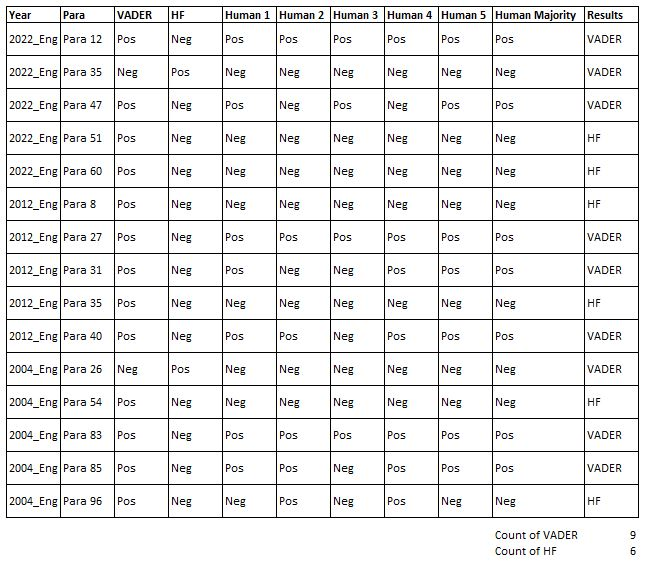